In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
power_p1 = pd.read_csv('raw_data/Plant_1_Generation_Data.csv')
weather_p1 = pd.read_csv('raw_data/Plant_1_Weather_Sensor_Data.csv')

power_p1['DATE_TIME'] = pd.to_datetime(power_p1['DATE_TIME'])
weather_p1['DATE_TIME'] = pd.to_datetime(weather_p1['DATE_TIME'])
power_p1 = power_p1.drop(columns=['PLANT_ID'])
weather_p1 = weather_p1.drop(columns=['PLANT_ID','SOURCE_KEY'])

df = pd.merge(power_p1, weather_p1, on='DATE_TIME', how='left')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            68778 non-null  datetime64[ns]
 1   SOURCE_KEY           68778 non-null  object        
 2   DC_POWER             68778 non-null  float64       
 3   AC_POWER             68778 non-null  float64       
 4   DAILY_YIELD          68778 non-null  float64       
 5   TOTAL_YIELD          68778 non-null  float64       
 6   AMBIENT_TEMPERATURE  68774 non-null  float64       
 7   MODULE_TEMPERATURE   68774 non-null  float64       
 8   IRRADIATION          68774 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 4.7+ MB
None


/tmp/ipykernel_4092/863922379.py:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  power_p1['DATE_TIME'] = pd.to_datetime(power_p1['DATE_TIME'])


## Check for missing data

In [54]:
start = df['DATE_TIME'].min()
end = df['DATE_TIME'].max()
expected_range = pd.date_range(start=start, end=end, freq='15min')

actual_timestamps = df['DATE_TIME'].unique()
missing_timestamps = expected_range[~expected_range.isin(actual_timestamps)]

print(f"Total expected timestamps: {len(expected_range)}")
print(f"Missing timestamps in dataset: {len(missing_timestamps)}")
if len(missing_timestamps) > 0:
    print(f"First 5 missing: {missing_timestamps[:5].tolist()}")

Total expected timestamps: 3264
Missing timestamps in dataset: 106
First 5 missing: [Timestamp('2020-05-15 23:15:00'), Timestamp('2020-05-15 23:30:00'), Timestamp('2020-05-15 23:45:00'), Timestamp('2020-05-16 00:00:00'), Timestamp('2020-05-16 00:15:00')]


In [55]:
unique_inverters = df['SOURCE_KEY'].unique()

grid = pd.MultiIndex.from_product([expected_range, unique_inverters], names=['DATE_TIME', 'SOURCE_KEY']).to_frame(index=False)

check_df = pd.merge(grid, df, on=['DATE_TIME', 'SOURCE_KEY'], how='left')

missing_rows = check_df[check_df['AC_POWER'].isna()]

print(f"Total expected records (Timestamps * Inverters): {len(grid)}")
print(f"Actual records in file: {len(df)}")
print(f"Missing records: {len(missing_rows)}")

if not missing_rows.empty:
    print("\nMissing records per inverter:")
    print(missing_rows.groupby('SOURCE_KEY').size().sort_values(ascending=False))

Total expected records (Timestamps * Inverters): 71808
Actual records in file: 68778
Missing records: 3030

Missing records per inverter:
SOURCE_KEY
YxYtjZvoooNbGkE    160
3PZuoBAID5Wc2HD    146
WRmjgnKYAwPKWDb    146
adLQvlD726eNBSB    145
zBIq5rxdHJRwDNY    145
1IF53ai7Xc0U56Y    145
ZoEaEvLYb1n2sOq    141
sjndEbLyjtCKgGv    140
rGa61gmuvPhdLxV    140
McdE0feGgRqW7Ca    140
zVJPv84UY57bAof    140
uHbuxQJl8lW7ozc    139
iCRJl6heRkivqQ3    139
pkci93gMrogZuBj    139
wCURE6d3bPkepu2    138
z9Y9gH1T5YWrNuG    138
ih0vzX44oOqAx2f    134
ZnxXDlPa8U1GXgE    134
7JYdWkrLSPkdwr4    131
VHMLBKoKgIrUVDU    131
1BY6WEcLGh8j5v7    110
bvBOhCH3iADSZry    109
dtype: int64


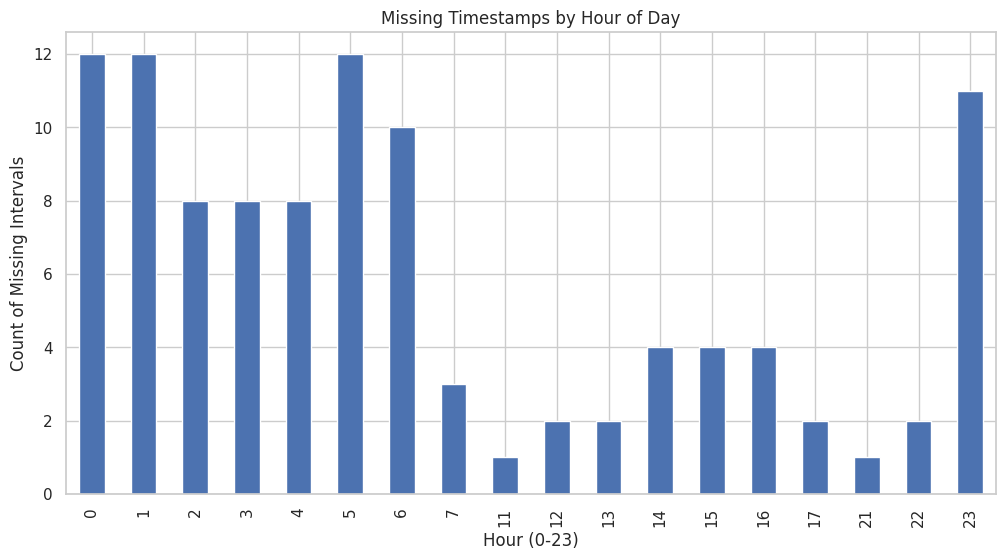

In [56]:
missing_ts_df = pd.DataFrame(missing_timestamps, columns=['DATE_TIME'])

missing_ts_df['hour'] = missing_ts_df['DATE_TIME'].dt.hour

gap_counts = missing_ts_df['hour'].value_counts().sort_index()

gap_counts.plot(kind='bar', title='Missing Timestamps by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Count of Missing Intervals')
plt.show()
# mostly at night, but also during the day

## Creation of a complete dataset

In [57]:
power_p1 = pd.read_csv('raw_data/Plant_1_Generation_Data.csv')
weather_p1 = pd.read_csv('raw_data/Plant_1_Weather_Sensor_Data.csv')

power_p1['DATE_TIME'] = pd.to_datetime(power_p1['DATE_TIME'], dayfirst=True)
weather_p1['DATE_TIME'] = pd.to_datetime(weather_p1['DATE_TIME'], dayfirst=True)

all_times = pd.date_range(start=power_p1['DATE_TIME'].min(), end=power_p1['DATE_TIME'].max(), freq='15min')
unique_inverters = power_p1['SOURCE_KEY'].unique()

grid = pd.MultiIndex.from_product([all_times, unique_inverters], names=['DATE_TIME', 'SOURCE_KEY']).to_frame(index=False)

power_p1 = power_p1.drop(columns=['PLANT_ID'])
weather_p1 = weather_p1.drop(columns=['PLANT_ID','SOURCE_KEY'], errors='ignore')

df = pd.merge(grid, power_p1, on=['DATE_TIME', 'SOURCE_KEY'], how='left')
df = pd.merge(df, weather_p1, on='DATE_TIME', how='left')

# interpolate weather data
weather_cols = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
df[weather_cols] = df[weather_cols].interpolate(method='linear')

is_night = df['IRRADIATION'] < 0.005
df.loc[is_night, ['DC_POWER', 'AC_POWER']] = df.loc[is_night, ['DC_POWER', 'AC_POWER']].fillna(0)

df['DC_POWER'] = df.groupby('SOURCE_KEY')['DC_POWER'].transform(lambda x: x.interpolate(method='linear'))
df['AC_POWER'] = df.groupby('SOURCE_KEY')['AC_POWER'].transform(lambda x: x.interpolate(method='linear'))

df['DAILY_YIELD'] = df.groupby('SOURCE_KEY')['DAILY_YIELD'].ffill()
df['TOTAL_YIELD'] = df.groupby('SOURCE_KEY')['TOTAL_YIELD'].ffill()

df = df.sort_values(['DATE_TIME', 'SOURCE_KEY']).reset_index(drop=True)

print(f"Missing values remaining: \n{df.isna().sum()}")

Missing values remaining: 
DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            4
TOTAL_YIELD            4
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


/tmp/ipykernel_4092/1822289033.py:5: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  weather_p1['DATE_TIME'] = pd.to_datetime(weather_p1['DATE_TIME'], dayfirst=True)


In [58]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71808 entries, 0 to 71807
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            71808 non-null  datetime64[ns]
 1   SOURCE_KEY           71808 non-null  object        
 2   DC_POWER             71808 non-null  float64       
 3   AC_POWER             71808 non-null  float64       
 4   DAILY_YIELD          71804 non-null  float64       
 5   TOTAL_YIELD          71804 non-null  float64       
 6   AMBIENT_TEMPERATURE  71808 non-null  float64       
 7   MODULE_TEMPERATURE   71808 non-null  float64       
 8   IRRADIATION          71808 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 4.9+ MB
None


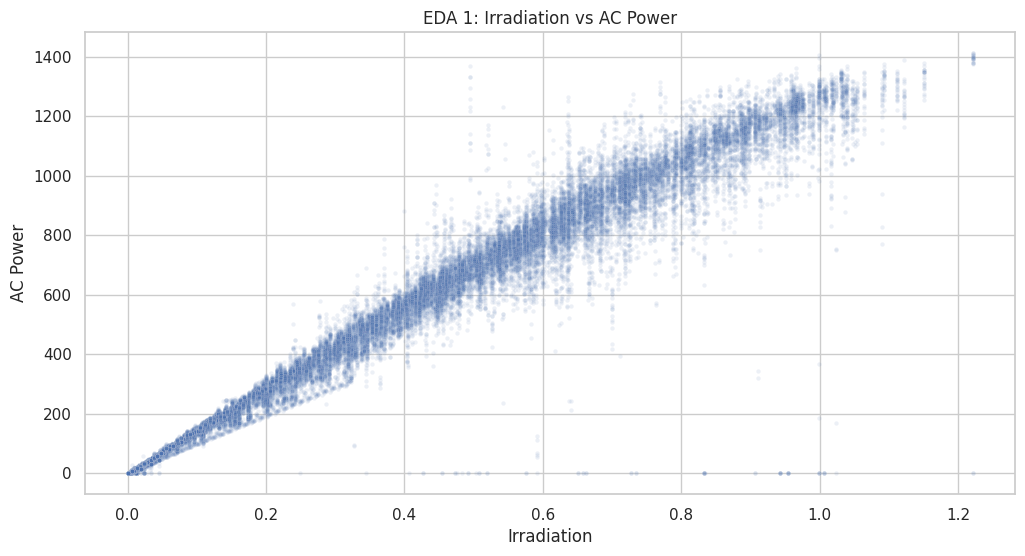

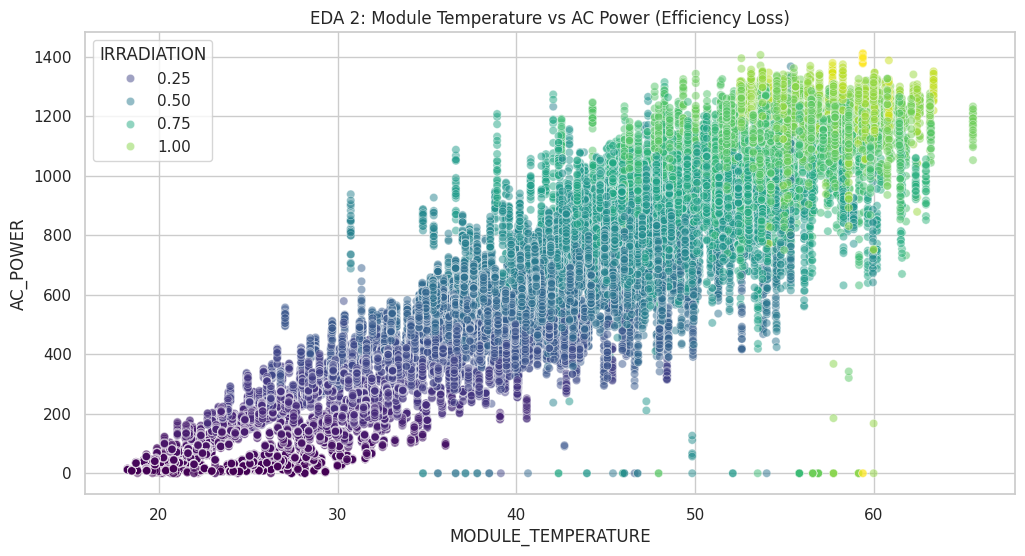

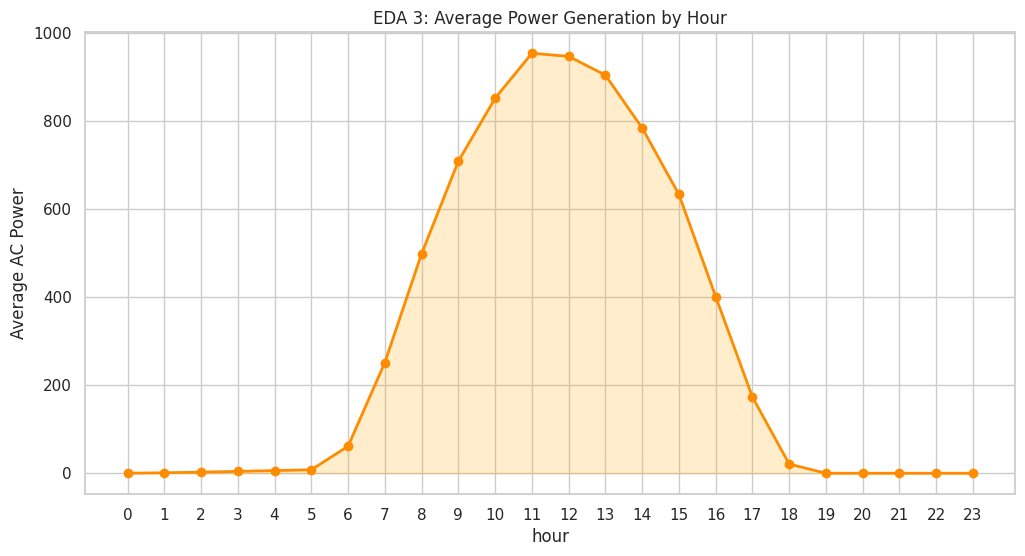

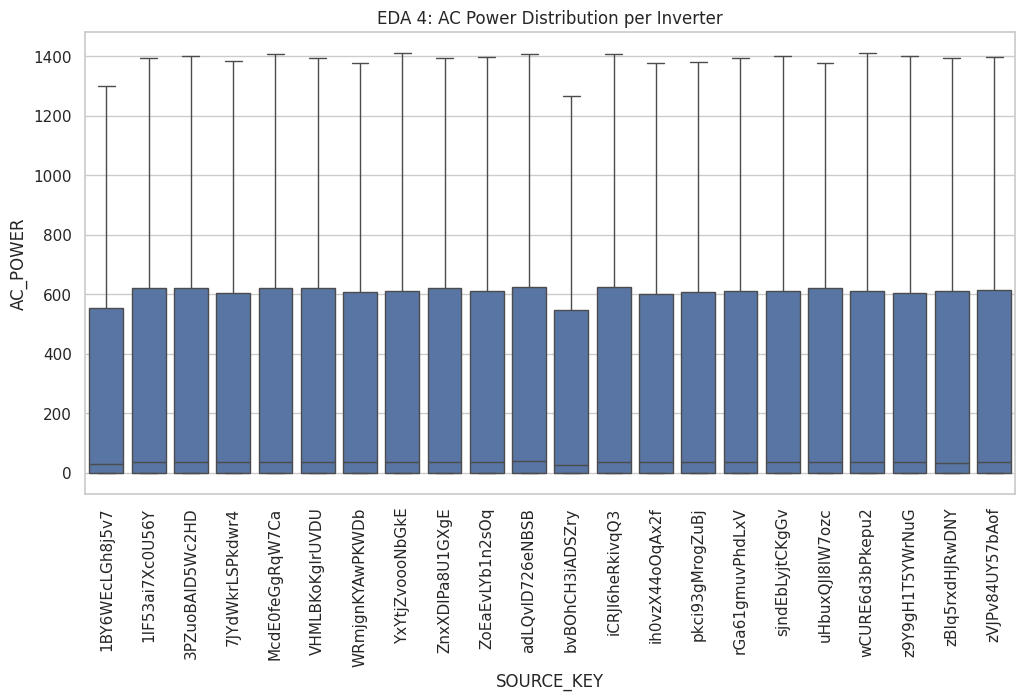

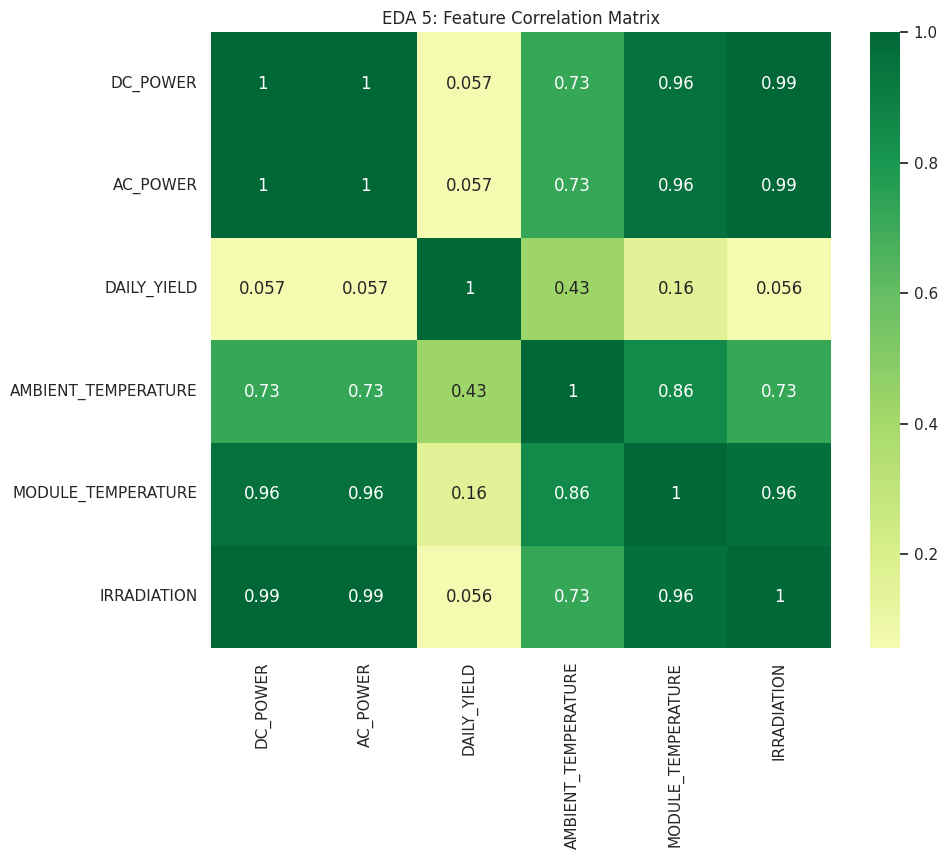

In [59]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# check relation between target and irradiation
plt.figure()
sns.scatterplot(data=df, x='IRRADIATION', y='AC_POWER', alpha=0.1, s=10)
plt.title('EDA 1: Irradiation vs AC Power')
plt.xlabel('Irradiation')
plt.ylabel('AC Power')
plt.show()

daytime_df = df[df['IRRADIATION'] > 0.005]
plt.figure()
sns.scatterplot(data=daytime_df, x='MODULE_TEMPERATURE', y='AC_POWER', hue='IRRADIATION', palette='viridis', alpha=0.5)
plt.title('EDA 2: Module Temperature vs AC Power (Efficiency Loss)')
plt.show()

df['hour'] = df['DATE_TIME'].dt.hour
plt.figure()
hourly_avg = df.groupby('hour')['AC_POWER'].mean()
hourly_avg.plot(kind='line', marker='o', color='darkorange', lw=2)
plt.fill_between(hourly_avg.index, hourly_avg, color='orange', alpha=0.2)
plt.title('EDA 3: Average Power Generation by Hour')
plt.ylabel('Average AC Power')
plt.xticks(range(0, 24))
plt.show()
df = df.drop(columns=['hour'])

plt.figure()
sns.boxplot(data=df, x='SOURCE_KEY', y='AC_POWER')
plt.xticks(rotation=90)
plt.title('EDA 4: AC Power Distribution per Inverter')
plt.show()

# check feature correlation
plt.figure(figsize=(10, 8))
corr_matrix = df[['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0)
plt.title('EDA 5: Feature Correlation Matrix')
plt.show()

## Prepare data for the model

In [60]:
df = df.drop(columns=['TOTAL_YIELD', 'DAILY_YIELD', 'DC_POWER'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71808 entries, 0 to 71807
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            71808 non-null  datetime64[ns]
 1   SOURCE_KEY           71808 non-null  object        
 2   AC_POWER             71808 non-null  float64       
 3   AMBIENT_TEMPERATURE  71808 non-null  float64       
 4   MODULE_TEMPERATURE   71808 non-null  float64       
 5   IRRADIATION          71808 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 3.3+ MB
None


In [61]:
# take care of wild 0 outliers
irrad_threshold = 0.005
false_zero_mask = (df['IRRADIATION'] > irrad_threshold) & (df['AC_POWER'] == 0)

print(f"Detected {false_zero_mask.sum()} False Zero records during daytime.")

df.loc[false_zero_mask, ['AC_POWER']] = np.nan

df['AC_POWER'] = df.groupby('SOURCE_KEY')['AC_POWER'].transform(lambda x: x.interpolate(method='linear'))

df['AC_POWER'] = df['AC_POWER'].fillna(0)

Detected 123 False Zero records during daytime.


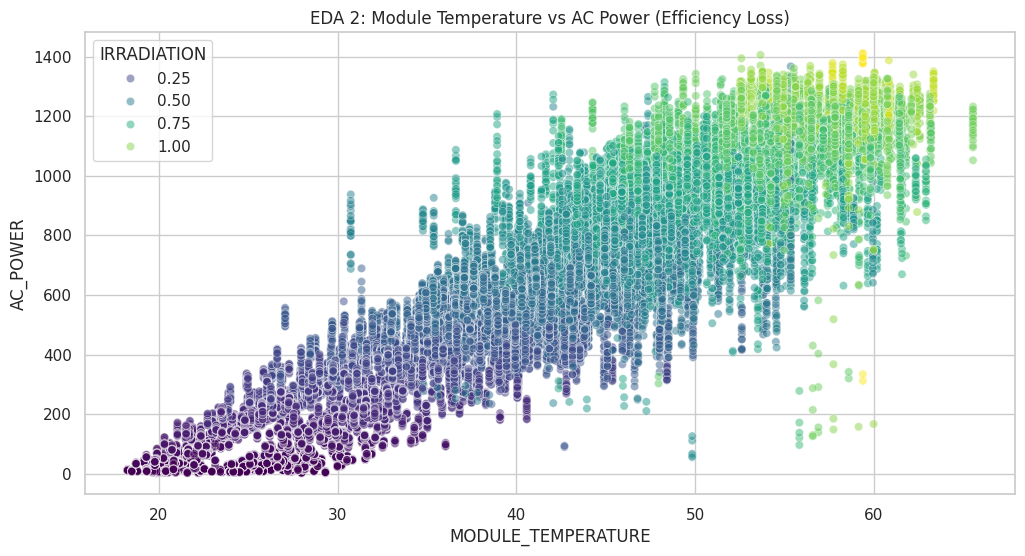

In [62]:
daytime_df = df[df['IRRADIATION'] > 0.005]
plt.figure()
sns.scatterplot(data=daytime_df, x='MODULE_TEMPERATURE', y='AC_POWER', hue='IRRADIATION', palette='viridis', alpha=0.5)
plt.title('EDA 2: Module Temperature vs AC Power (Efficiency Loss)')
plt.show()
# no more wild 0s

## Dataset 2

In [63]:
power_p2 = pd.read_csv('raw_data/Plant_2_Generation_Data.csv')
weather_p2 = pd.read_csv('raw_data/Plant_2_Weather_Sensor_Data.csv')

power_p2['DATE_TIME'] = pd.to_datetime(power_p2['DATE_TIME'], dayfirst=True)
weather_p2['DATE_TIME'] = pd.to_datetime(weather_p2['DATE_TIME'], dayfirst=True)

all_times = pd.date_range(start=power_p2['DATE_TIME'].min(), end=power_p2['DATE_TIME'].max(), freq='15min')
unique_inverters = power_p2['SOURCE_KEY'].unique()

grid = pd.MultiIndex.from_product([all_times, unique_inverters], names=['DATE_TIME', 'SOURCE_KEY']).to_frame(index=False)

power_p2 = power_p2.drop(columns=['PLANT_ID'])
weather_p2 = weather_p2.drop(columns=['PLANT_ID','SOURCE_KEY'], errors='ignore')

df2 = pd.merge(grid, power_p2, on=['DATE_TIME', 'SOURCE_KEY'], how='left')
df2 = pd.merge(df2, weather_p2, on='DATE_TIME', how='left')

# interpolate weather data
weather_cols = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
df2[weather_cols] = df2[weather_cols].interpolate(method='linear')

is_night = df2['IRRADIATION'] < 0.005
df2.loc[is_night, ['DC_POWER', 'AC_POWER']] = df2.loc[is_night, ['DC_POWER', 'AC_POWER']].fillna(0)

df2['DC_POWER'] = df2.groupby('SOURCE_KEY')['DC_POWER'].transform(lambda x: x.interpolate(method='linear'))
df2['AC_POWER'] = df2.groupby('SOURCE_KEY')['AC_POWER'].transform(lambda x: x.interpolate(method='linear'))

df2['DAILY_YIELD'] = df2.groupby('SOURCE_KEY')['DAILY_YIELD'].ffill()
df2['TOTAL_YIELD'] = df2.groupby('SOURCE_KEY')['TOTAL_YIELD'].ffill()

df2 = df2.sort_values(['DATE_TIME', 'SOURCE_KEY']).reset_index(drop=True)

print(f"Missing values remaining: \n{df2.isna().sum()}")

df2 = df2.drop(columns=['TOTAL_YIELD', 'DAILY_YIELD', 'DC_POWER'])
print(df2.info())

/tmp/ipykernel_4092/3582730293.py:4: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  power_p2['DATE_TIME'] = pd.to_datetime(power_p2['DATE_TIME'], dayfirst=True)
/tmp/ipykernel_4092/3582730293.py:5: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  weather_p2['DATE_TIME'] = pd.to_datetime(weather_p2['DATE_TIME'], dayfirst=True)


Missing values remaining: 
DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71808 entries, 0 to 71807
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            71808 non-null  datetime64[ns]
 1   SOURCE_KEY           71808 non-null  object        
 2   AC_POWER             71808 non-null  float64       
 3   AMBIENT_TEMPERATURE  71808 non-null  float64       
 4   MODULE_TEMPERATURE   71808 non-null  float64       
 5   IRRADIATION          71808 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 3.3+ MB
None


In [64]:
timestamp_medians = df2.groupby('DATE_TIME')[['AC_POWER']].median().reset_index()
timestamp_medians.columns = ['DATE_TIME', 'MEDIAN_AC']

df2 = pd.merge(df2, timestamp_medians, on='DATE_TIME', how='left')

false_zero_mask = (df2['IRRADIATION'] > irrad_threshold) & (df2['AC_POWER'] == 0)
print(f"Detected {false_zero_mask.sum()} False Zero records during daytime.")

df2.loc[false_zero_mask, 'AC_POWER'] = df2.loc[false_zero_mask, 'MEDIAN_AC']

df2 = df2.drop(columns=['MEDIAN_AC'])

df2['AC_POWER'] = df2.groupby('SOURCE_KEY')['AC_POWER'].transform(lambda x: x.interpolate(method='linear'))

print(f"Remaining zeros in daytime: {((df2['IRRADIATION'] > irrad_threshold) & (df2['AC_POWER'] == 0)).sum()}")

Detected 5475 False Zero records during daytime.
Remaining zeros in daytime: 930


In [65]:
false_zero_mask = (df2['IRRADIATION'] > irrad_threshold) & (df2['AC_POWER'] == 0)

print(f"Detected {false_zero_mask.sum()} False Zero records during daytime.")

df2.loc[false_zero_mask, ['AC_POWER']] = np.nan

df2['AC_POWER'] = df2.groupby('SOURCE_KEY')['AC_POWER'].transform(lambda x: x.interpolate(method='linear'))

df2['AC_POWER'] = df2['AC_POWER'].fillna(0)

Detected 930 False Zero records during daytime.


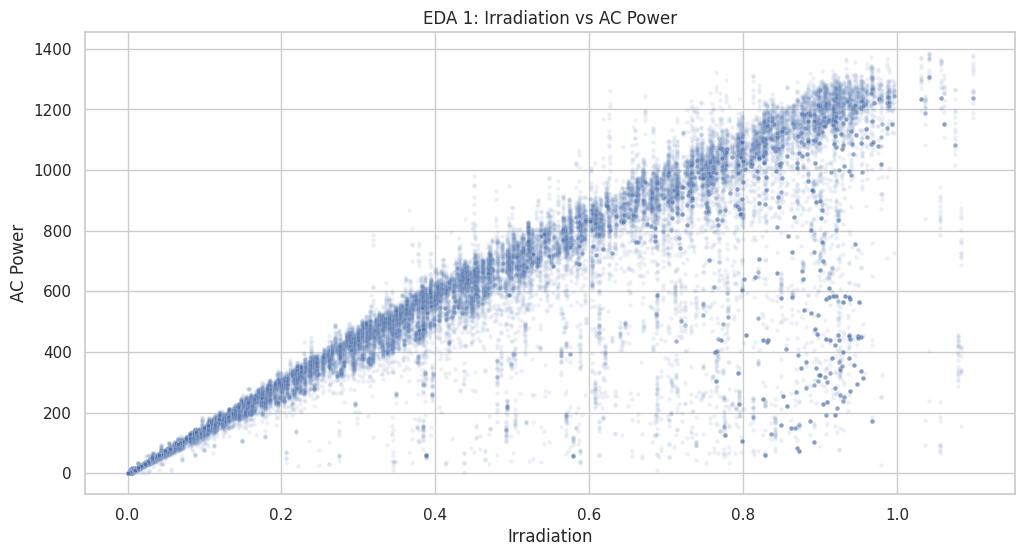

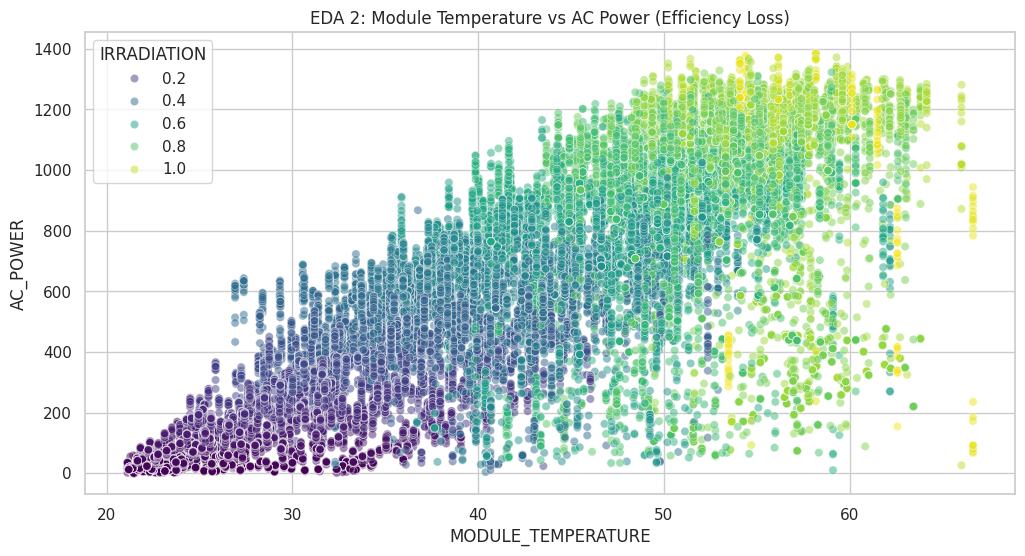

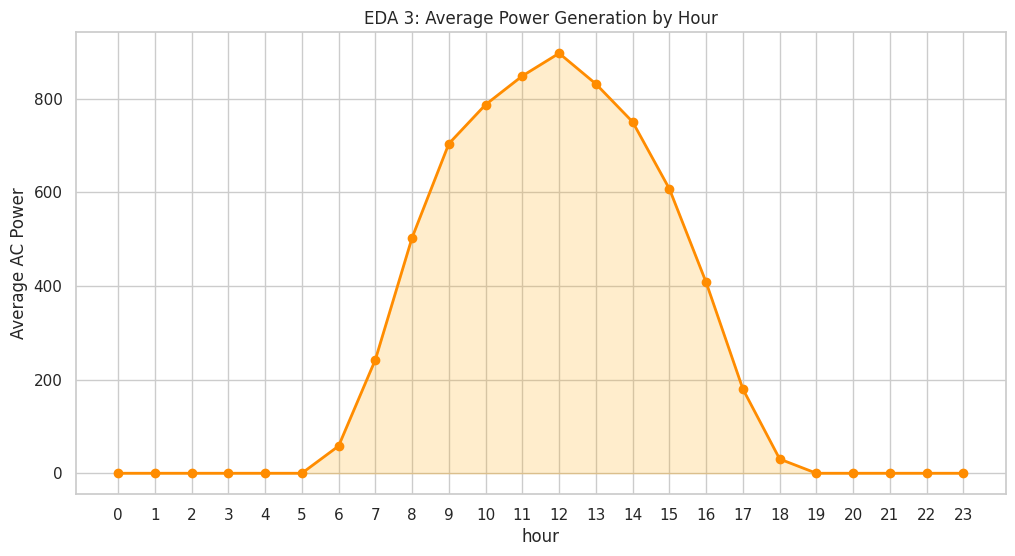

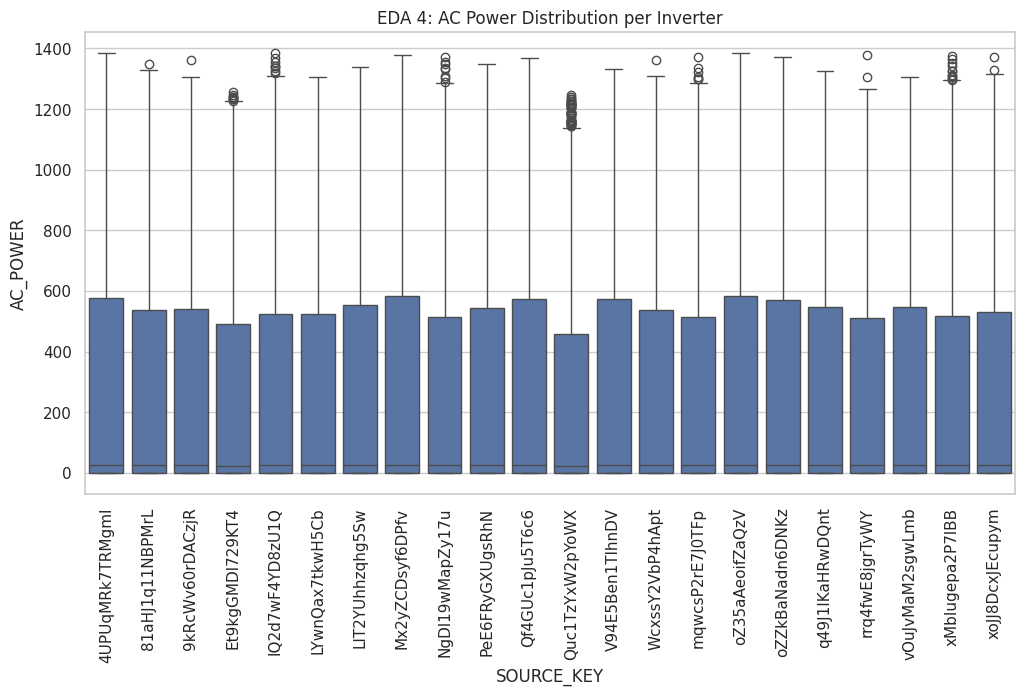

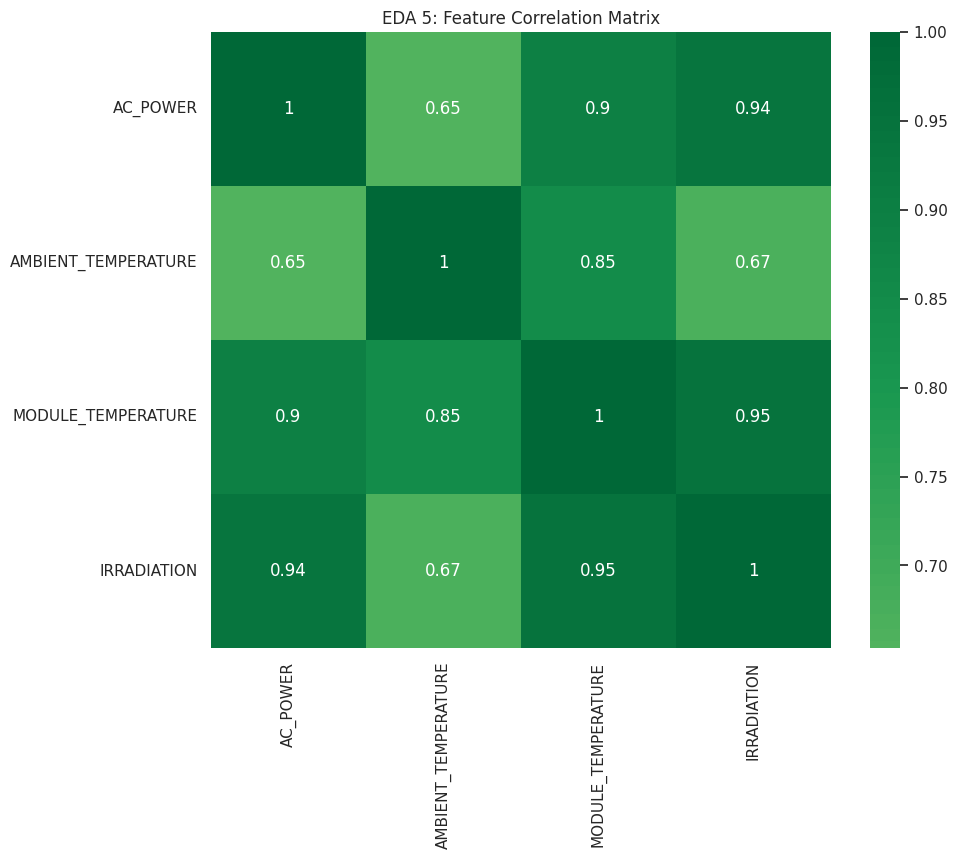

In [66]:
# check relation between target and irradiation
plt.figure()
sns.scatterplot(data=df2, x='IRRADIATION', y='AC_POWER', alpha=0.1, s=10)
plt.title('EDA 1: Irradiation vs AC Power')
plt.xlabel('Irradiation')
plt.ylabel('AC Power')
plt.show()

daytime_df2 = df2[df2['IRRADIATION'] > 0.005]
plt.figure()
sns.scatterplot(data=daytime_df2, x='MODULE_TEMPERATURE', y='AC_POWER', hue='IRRADIATION', palette='viridis', alpha=0.5)
plt.title('EDA 2: Module Temperature vs AC Power (Efficiency Loss)')
plt.show()

df2['hour'] = df2['DATE_TIME'].dt.hour
plt.figure()
hourly_avg = df2.groupby('hour')['AC_POWER'].mean()
hourly_avg.plot(kind='line', marker='o', color='darkorange', lw=2)
plt.fill_between(hourly_avg.index, hourly_avg, color='orange', alpha=0.2)
plt.title('EDA 3: Average Power Generation by Hour')
plt.ylabel('Average AC Power')
plt.xticks(range(0, 24))
plt.show()
df2 = df2.drop(columns=['hour'])

plt.figure()
sns.boxplot(data=df2, x='SOURCE_KEY', y='AC_POWER')
plt.xticks(rotation=90)
plt.title('EDA 4: AC Power Distribution per Inverter')
plt.show()

# check feature correlation
plt.figure(figsize=(10, 8))
corr_matrix = df2[['AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0)
plt.title('EDA 5: Feature Correlation Matrix')
plt.show()

## Export datasets

In [67]:
df.to_csv('cleaned_data/solar_1.csv')
df2.to_csv('cleaned_data/solar_2.csv')